## -*- coding: utf-8 -*-


Transfer Learning for Computer Vision Using PyTorch and Flask
====================================================
**Author**: `Isack Odero`

`In this tutorial, you will learn how to train a convolutional neural network for
 image classification using transfer learning and also How to wrap your trained 
 PyTorch model in a Flask container to expose it via a web API`

In this recipe, you will learn:

In Transfer Learning:

-  How to Load your datasets 
-  How to Visualize your datasets
-  How to Write a general function to training your model
-  How to Finetuning the Conv Net
-  How to run Conv Net as Feature extractor
-  How to save your model

In Deploying your Modelwith Flask:

-  How to wrap your trained PyTorch model in a Flask container to expose
   it via a web API
-  How to translate incoming web requests into PyTorch tensors for your
   model
-  How to package your model’s output for an HTTP response

Requirements
------------

You will need a Python 3 environment with the following packages (and
their dependencies) installed:

-  PyTorch 
-  TorchVision 
-  Matplotlib.pyplot
-  copy
-  os
-  numpy
-  Flask 1.1 

### Introduction to Transfer Learning

Transfer Learning:

-  In practice, very few people train an entire Convolutional
   Network from scratch , because it is relatively rare to have a dataset of sufficient size. Instead, it is
   common to pretrain a ConvNet on a very large dataset (e.g.
   ImageNet, which contains 1.2 million images with 1000
   categories), and then use the ConvNet either as an initialization
   or a fixed feature extractor for the task of interest.



Transfer Learning scenarios:

-  1: ConvNet as fixed feature extractor.
      -   Here we freeze the weights and bias of all network except thatof fully connected layer, 
          then this fully connected layer is trained and it' weight and bias are replaced with new ones. 
          
          
          
          
-  2: Fine-tuning the ConvNet..
      -   Here we initialize our Network using pretrained Network and train it. Here we do not initialize our               network randomly.  It is possible to fine-tune all the layers of the ConvNet, or it’s possible to keep             some of the earlier layers fixed (due to overfitting concerns) and only fine-tune some higher-level               portion of the network. 
      
      
      
          
-  3: Pretrained models.
      -   Since modern ConvNets can take weeks to train across multiple GPUs on ImageNet, it is common to see               people release their final ConvNet checkpoints for the benefit of others who can use the networks for             fine-tuning. 

When and how to fine-tune?:
-  Important ones are the size of the new dataset (small or big), and its similarity to the original dataset.




   -  1: New dataset is small and similar to original dataset.
      -   Since the data is small, it is not a good idea to fine-tune the ConvNet due to overfitting concerns.               Since the data is similar to the original data, we expect higher-level features in the ConvNet to be               relevant to this dataset as well. Hence, the best idea might be to train a linear classifier on the CNN           codes.
          
          
          
          
   -  2: New dataset is large and similar to the original dataset.
      -   Since we have more data, we can have more confidence that we won’t overfit if we were to try to fine -             tune through the full network.
      
      
      
          
   -  3: New dataset is small but very different from the original dataset.
      -   Since the data is small, it is likely best to only train a linear classifier. Since the dataset is very           different, it might not be best to train the classifier from the top of the network, which contains more           dataset-specific features. Instead, it might work better to train the SVM classifier from activations             somewhere earlier in the network. 
            
      
      
          
   -  4: New dataset is large and very different from the originaldataset.
      -   Since the dataset is very large, we may expect that we can afford to train a ConvNet from scratch.                 However, in practice it is very often still beneficial to initialize with weights from a pretrained               model. In this case, we would have enough data and confidence to fine-tune through the entire network.

### Define the Problem.
-  The problem we’re going to solve today is to train a model to classify ants and bees. We have about 120            training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very    small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be
   able to generalize reasonably well




   -  This dataset is a very small subset of imagenet.
  

**Author**: `Isack Odero`

In [1]:
import torch
import torchvision
from torchvision import transforms, models, datasets

import numpy as np
import matplotlib.pyplot as plt
import os
import copy

plt.ion()

print("Torch Version: {} \nTorchVision Version: {}".format(torch.__version__, torchvision.__version__))

Torch Version: 1.10.0+cu102 
TorchVision Version: 0.11.1+cu102



Load Data
---------------

-  We will use `torchvision` and `torch.utils.data` packages for:

   - loading the data.

   -  Data augmentation and normalization for training
   
   
   
note: `data_dir is the root directory where you put your data in your computer, in which for me is "/home/isack/Desktop/PyCon Tanzania 2021/data"`

In [2]:
# This is my directory
data_dir="/home/isack/Desktop/PyCon Tanzania 2021/data"

# Data augmentation and normalization
transform = {
    "train": transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225])
    ])
}

# Load dataset
dataset = {x: datasets.ImageFolder(root = os.path.join(data_dir, x), transform = transform[x]) for x in ["train", "val"]}

# Make your dataset iteratible and define your batch_size, shuffle and num_workers
dataloader = {x: torch.utils.data.DataLoader(dataset[x], batch_size = 4, shuffle=True, num_workers= 0) for x in ["train", "val"]}

# Define my dataset size
dataset_sizes = {x: len(dataset[x]) for x in ["train","val"]}

# Define my device
device = torch.device("cuda :0") if torch.cuda.is_available() else print("cpu")

cpu


/home/isack/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


Visualize a few images
-------------------------------

-  Let's visualize a few training images so as to understand the data augmentations.

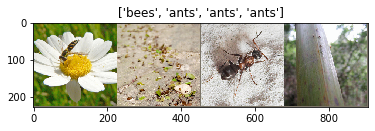

In [3]:
def show(imgs, title=None):
    np_imgs = imgs.numpy().transpose(1, 2, 0)
    mean = [0.485, 0.456, 0.406] 
    std = [0.229, 0.224, 0.225]
    np_imgs= np_imgs*std + mean
    
    np_imgs= np.clip(np_imgs, 0, 1)
    plt.imshow(np_imgs)
    plt.title(title)

# Get your batch training dataset    
inputs, labels = next(iter(dataloader["val"]))

# Make a grid from batch
imgs = torchvision.utils.make_grid(inputs)

# Showing my images
show(imgs, title = [dataset["val"].classes[x] for x in labels])

 Training the model
 ------------------

-   Now, let's write a general function to train a model. Here, we will illustrate:


     -  Scheduling the learning rate
    
     -  Saving the best model
     
-   In the following, parameter ``scheduler`` is an LR scheduler object from ``torch.optim.lr_scheduler``.

In [4]:
def NN(model, optimizer, criterion, scheduler, dataset_size, num_epoch):
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epoch):
        
        epoch_loss = 0.0
        epoch_acc = 0
        
        print("{}/{}".format(epoch+1, num_epoch))
        
        # Each epoch has a training and validation phase
        for phase in ["train","val"]:
            
            # Set model to training mode
            if phase =="train":
                model.train()  
            
            # Set model to evaluate mode
            if phase == "val":
                model.eval()   
            
            running_loss = 0.0
            running_acc = 0
            
            # Iterate over data.
            for inputs, labels in dataloader[phase]:
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    
                    #Forward Propagation
                    output = model(inputs)
                    _,pred = torch.max(output, 1)
                    
                    #Loss 
                    loss = criterion(output, labels.data)
                    
                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        
                #Perform Statistic / To find our running Loss and Acc
                running_loss += loss.item() * inputs.size(0)
                running_acc += torch.sum(pred == labels.data)
                
            epoch_loss = running_loss / dataset_size[phase]
            epoch_acc = running_acc / dataset_size[phase]
            
            # Update our learning rate
            if phase == "train":
                scheduler.step()
                
            print("Phase: {}  Epoch Loss : {:.4f}  Epoch Acc : {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
                
            
        print()
        
    print("Best Acc : {}".format(best_acc))
    
    # Load best models weights
    model.load_state_dict(best_model)
    
    return model
            

Finetuning the convnet
 ----------------------
 
 -  Load a pretrained model and reset final fully connected layer.

In [5]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
model_ft.fc = torch.nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = torch.nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


 Train and evaluate:
 
 -  It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [6]:
model_ft = NN(model = model_ft, optimizer = optimizer_ft, criterion = criterion, scheduler = exp_lr_scheduler, dataset_size = dataset_sizes, num_epoch = 10)

1/10
Phase: train  Epoch Loss : 0.7161  Epoch Acc : 0.6333
Phase: val  Epoch Loss : 0.5941  Epoch Acc : 0.6875

2/10
Phase: train  Epoch Loss : 0.5257  Epoch Acc : 0.6667
Phase: val  Epoch Loss : 0.4443  Epoch Acc : 0.8125

3/10
Phase: train  Epoch Loss : 0.4850  Epoch Acc : 0.7667
Phase: val  Epoch Loss : 0.4083  Epoch Acc : 0.8750

4/10
Phase: train  Epoch Loss : 0.5737  Epoch Acc : 0.8000
Phase: val  Epoch Loss : 0.3860  Epoch Acc : 0.8750

5/10
Phase: train  Epoch Loss : 0.3858  Epoch Acc : 0.8667
Phase: val  Epoch Loss : 0.6984  Epoch Acc : 0.6562

6/10
Phase: train  Epoch Loss : 0.3497  Epoch Acc : 0.8667
Phase: val  Epoch Loss : 0.5259  Epoch Acc : 0.8438

7/10
Phase: train  Epoch Loss : 0.2036  Epoch Acc : 0.9000
Phase: val  Epoch Loss : 0.4719  Epoch Acc : 0.8438

8/10
Phase: train  Epoch Loss : 0.3323  Epoch Acc : 0.9000
Phase: val  Epoch Loss : 0.4781  Epoch Acc : 0.8438

9/10
Phase: train  Epoch Loss : 0.1823  Epoch Acc : 0.8667
Phase: val  Epoch Loss : 0.4535  Epoch Acc : 

ConvNet as fixed feature extractor
 ----------------------------------
 
-  Here, we need to freeze all the network except the final layer. We need to set ``requires_grad == False`` to freeze the parameters so that the gradients are not computed in ``backward()``.

In [7]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = torch.nn.Linear(num_ftrs, 2, bias=True)

model_conv = model_conv.to(device)

criterion = torch.nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as opposed to before.
optimizer_conv = torch.optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate:

-   On CPU this will take about half the time compared to previous scenario. This is expected as gradients don't need to be computed for most of the network. However, forward does need to be computed.



In [8]:

model_conv =  NN(model = model_conv, optimizer = optimizer_conv, criterion = criterion, scheduler = exp_lr_scheduler, dataset_size = dataset_sizes, num_epoch = 10)

1/10
Phase: train  Epoch Loss : 0.7128  Epoch Acc : 0.6000
Phase: val  Epoch Loss : 0.7701  Epoch Acc : 0.5938

2/10
Phase: train  Epoch Loss : 0.7914  Epoch Acc : 0.4667
Phase: val  Epoch Loss : 0.7774  Epoch Acc : 0.5312

3/10
Phase: train  Epoch Loss : 0.6273  Epoch Acc : 0.6000
Phase: val  Epoch Loss : 0.6287  Epoch Acc : 0.6250

4/10
Phase: train  Epoch Loss : 0.6552  Epoch Acc : 0.6333
Phase: val  Epoch Loss : 0.4885  Epoch Acc : 0.7500

5/10
Phase: train  Epoch Loss : 0.5097  Epoch Acc : 0.7333
Phase: val  Epoch Loss : 0.3679  Epoch Acc : 0.8750

6/10
Phase: train  Epoch Loss : 0.3557  Epoch Acc : 0.8667
Phase: val  Epoch Loss : 0.3536  Epoch Acc : 0.9062

7/10
Phase: train  Epoch Loss : 0.2648  Epoch Acc : 0.9333
Phase: val  Epoch Loss : 0.3518  Epoch Acc : 0.9062

8/10
Phase: train  Epoch Loss : 0.4394  Epoch Acc : 0.7667
Phase: val  Epoch Loss : 0.3401  Epoch Acc : 0.9062

9/10
Phase: train  Epoch Loss : 0.2522  Epoch Acc : 0.9667
Phase: val  Epoch Loss : 0.3389  Epoch Acc : 

In [9]:
#saving  model
path= "/home/isack/Desktop/PyCon Tanzania 2021/saved_model/resnet152.pth"

model = torch.save(model, path)

NameError: name 'model' is not defined

Deploying with Flask
====================

In this tutorial, we will deploy a PyTorch model using Flask and expose a REST API for model inference.
Using Flask in this way is by far the easiest way to start serving your PyTorch models, 
but it will not work for a use case with high performance requirements.

For that:
- TorchScript, You will Load a TorchScript Model in C++ .

What is Flask?
--------------

Flask is a lightweight web server written in Python. It provides a
convenient way for you to quickly set up a web API for predictions from
your trained PyTorch model, either for direct use, or as a web service
within a larger system.


How to install Falsk Using pip 
----------------------------


In [ ]:
pip install Flask==2.0.1 torchvision==0.10.0

Building Your Flask Service
---------------------------

The full Python script for the Flask service is shown at the end of this
recipe; you can copy and paste that into your own ``app.py`` file. Below
we'll look at individual sections to make their functions clear.

All of this work is done in any IDE of your choice. Open your IDE start new project
and  you have to install flask in your system so that you can be able to import it 
in your project.

Imports
~~~~~~~

####  Simple Web Server

- Following is a simple webserver:



In [ ]:
from flask import Flask


app = Flask(__name__)

@app.route('/')

def hello():

return 'Hello World!'

#### To Run it

Open your terminal or cmd and go to the directory of your project and type:



In [ ]:
FLASK_ENV=development FLASK_APP=app.py flask run

####  How to render a template

- Following is a simple way to render template:



In [ ]:
from flask import Flask, render_template


app = Flask(__name__)

@app.route('/')

def hello():

return render_template 'index.html'

#### Inference
In this next sections we will focus on writing the inference code.

This will involve two parts,
- one where we prepare the image so that it can be fed to our model above

- we will write the code to get the actual prediction from the
  model.

#### Preparing the image
Our model requires the image to be of 3 channel RGB image of
size 224 x 224. We will also normalise the image tensor with the
required mean and standard deviation values.
We will use transforms from torchvision library and build a
transform pipeline, which transforms our images as required.
The method will be taking image data in bytes, applies the
series of transforms and returns a tensor.

In [ ]:

def transform_image(image_byte):

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(225),
        transforms.CenterCrop(224),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225])
    ])

    image=Image.open(io.BytesIO(image_byte))
    return transform(image).unsqueeze(0)


#### Prediction
Now will use a our model to predict the image class. We will use
one that we saved, load the model and get an inference.

In [ ]:


def prediction(model_path, image_byte, class_map):

    input = transform_image(image_byte=image_byte)
    
    model = torch.load(model_path)
    model.eval()

    output = model(input)
    _,pred = torch.max(output, 1)
    class_idx = pred.item()
    class_name = class_map[class_idx]

    return (class_idx, class_name)

#### Integrating the model in our API Server
In this final part we will add our model to our Flask API server.
Since our API server is supposed to take an image file, we will
update our predict method to read files from the requests:

In [ ]:


@app.route("/", methods=["POST", "GET"])


def predict():

    if request.method== "POST":
        file = request.files["image"]

        if file:
            file_loc = os.path.join(
                upload_folder, file.filename
            )
            file.save(file_loc)

            with open(file_loc, 'rb') as f:
                img_byte = f.read()
                class_idx, class_name = prediction(model_path=model_path, image_byte=img_byte, class_map=class_map)


            return render_template("result.html", class_idx= class_idx, class_name =class_name, file_loc= file_loc, file_name=file.filename)

       
    return render_template ("index.html", class_idx= "None", class_name =None, file_loc= None)

    

if __name__=="__main__":

    app.run(port=5000, debug=True)

It assumes that project folder is called FLASK_API and it organized in the following way: ::
---------------------------------------------------------------------
- `FLASK_API` (Folder)
   - `Static` (Folder)
      - css (File)
   - `template` (Folder)
      - index.html (File)
      - result.html (File)
      
   - app.py (File)

Running The Full Flask App
--------------------------

Paste the following into a file called ``app.py``:

In [ ]:
import os


import io


from PIL import Image

import torch


import torchvision


from torchvision import transforms


from flask import Flask, render_template, request, redirect, url_for




app = Flask(__name__)

upload_folder="/home/isack/Desktop/PyCon Tanzania 2021/Flask_API/static"


model_path = "/home/isack/Desktop/PyCon Tanzania 2021/saved_model/resnet152.pth"


class_map = {
    0 : "Ant",
    1: "Bee"
}

def transform_image(image_byte):

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(225),
        transforms.CenterCrop(224),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225])
    ])

    image=Image.open(io.BytesIO(image_byte))
    return transform(image).unsqueeze(0)

def prediction(model_path, image_byte, class_map):

    input = transform_image(image_byte=image_byte)
    
    model = torch.load(model_path)
    model.eval()

    output = model(input)
    _,pred = torch.max(output, 1)
    class_idx = pred.item()
    class_name = class_map[class_idx]

    return (class_idx, class_name)


@app.route("/", methods=["POST", "GET"])
def predict():

    if request.method== "POST":
        file = request.files["image"]

        if file:
            file_loc = os.path.join(
                upload_folder, file.filename
            )
            file.save(file_loc)

            with open(file_loc, 'rb') as f:
                img_byte = f.read()
                class_idx, class_name = prediction(model_path=model_path, image_byte=img_byte, class_map=class_map)


            return render_template("result.html", class_idx= class_idx, class_name =class_name, file_loc= file_loc, file_name=file.filename)

       
    return render_template ("index.html", class_idx= "None", class_name =None, file_loc= None)

    

if __name__=="__main__":

    app.run(port=5000, debug=True)

#### My index html template

In [ ]:


<!DOCTYPE html>
<!--[if lt IE 7]>      <html class="no-js lt-ie9 lt-ie8 lt-ie7"> <![endif]-->
<!--[if IE 7]>         <html class="no-js lt-ie9 lt-ie8"> <![endif]-->
<!--[if IE 8]>         <html class="no-js lt-ie9"> <![endif]-->
<!--[if gt IE 8]>      <html class="no-js"> <!--<![endif]-->
<html>
    <head>
        <meta charset="utf-8">
        <meta http-equiv="X-UA-Compatible" content="IE=edge">
        <meta name="description" content="">
        <meta name="viewport" content="width=device-width, initial-scale=1">
        
        <!--Bootstrap Core CSS-->
        <link href="/static/css/bootstrap.min.css" rel="stylesheet">
        
        <!--Custom styles for this template-->
        <link rel="stylesheet" href="/static/css/form_upload.css">

        <title>Bees & Ants</title>
    </head>
    <body class="text-center">
        <form class="form-upload" method=post enctype=multipart/form-data>
          <h4 class="h3 mb-3 font-weight-normal">Classification of Ant and Bee Images</h4>
          <br>
          <h4 class="h3 mb-3 font-weight-normal">Please Upload Image</h4>
          <input type="file" name="image" id="image" class="form-control" required autofocus>
          <button class="btn btn-lg btn-primary btn-block " type="submit">Predict</button>
          <br>

          {% if file_loc==None %}
             <h3 class="h3 mb-3 font-weight-normal">Prediction : {{class_idx}}</h3>
          {% endif %}

        </form>
        <script src="" async defer></script>
    </body>
</html>

#### My Result html template

In [ ]:


<!DOCTYPE html>
<!--[if lt IE 7]>      <html class="no-js lt-ie9 lt-ie8 lt-ie7"> <![endif]-->
<!--[if IE 7]>         <html class="no-js lt-ie9 lt-ie8"> <![endif]-->
<!--[if IE 8]>         <html class="no-js lt-ie9"> <![endif]-->
<!--[if gt IE 8]>      <html class="no-js"> <!--<![endif]-->
<html>
    <head>
        <meta charset="utf-8">
        <meta http-equiv="X-UA-Compatible" content="IE=edge">
        <meta name="description" content="">
        <meta name="viewport" content="width=device-width, initial-scale=1">
        
        <!--Bootstrap Core CSS-->
        <link href="/static/css/bootstrap.min.css" rel="stylesheet">
        
        <!--Custom styles for this template-->
        <link rel="stylesheet" href="/static/css/form_upload.css">

        <title>Bees & Ants</title>
    </head>
    <body class="text-center">
        <form class="form-upload" method=post enctype=multipart/form-data>
          <h4 class="h3 mb-3 font-weight-normal">My Prediction</h4>
          <br>

          {%if file_loc%}
             <img class="mb-4" src=static/{{file_name}} alt="Not Loaded" width="224" height="224" />
             
             <h3 class="h3 mb-3 font-weight-normal">Prediction : {{class_idx}}</h3>
             <br>
             <h3 class="h3 mb-3 font-weight-normal"> {{class_name}}  Image</h3>
             <br>
             <a class="btn btn-lg btn-primary btn-block " href="/"> back</a>
          {%endif%}

        </form>
        <script src="" async defer></script>
    </body>
</html>

You can find the css file 
 - you can download it here



In [ ]:
https://github.com/twbs/bootstrap/releases/download/v4.0.0/bootstrap-4.0.0-dist.zip

You can find the data file 
 - you can download it here

In [ ]:
https://download.pytorch.org/tutorial/hymenoptera_data.zip